# Data Challlenge: Help a Hematologist out!
## Starter pack

![logo](https://github.com/christinab12/Data-challenge-logo/blob/main/logo.jpg?raw=true)

## Getting started

This notebook will get you started with downloading, exploring and analyzing the input and output data of the challenge, running a baseline model and creating a submission file to upload to the leaderboard.

The challenge here is in transfer learning, precisely domain generalization (DG) and domain adaptation (DA) techniques. The focus lies on using deep neural networks to classify single white blood cell images obtained from peripheral blood smears. 

Three datasets, each constituting a different domain, will be used for this challenge:
1. The Acevedo_20 dataset with labels
2. The Matek_19 dataset with labels
3. The WBC dataset without labels (Used for domain adaptation and performance measurement)

The Acevedo_20 and Matek_19 datasets are labeled and should be used to train the model for the domain generalization task.
A small subpart of the WBC dataset, WBC1, will be downloadable from the beginning of the challenge. It is unlabeled and should be used for evaluation and domain adaptation techniques.
A second similar subpart of the WBC dataset, WBC2, will become available for download during phase 2 of the challenge, i.e. on the last day, 24 hours before submissions close.
Tthe goal of this challenge is to achieve a high performance, especially a high f1 macro score, on the WBC2 dataset.

This challenge wants to motivate research in domain generalization and adaptation techniques:

To make actual use of deep learning in the medical routine, it is important that the techniques can be used in realistic cases. If a peripheral blood smear is acquired from a patient and classified by a neural network, it is important that this works reliably. But the patient’s blood smear might very likely vary compared to the image domains used as training data of the network, resulting in not trustable results. To overcome this obstacle and build robust domain-invariant classifiers research in domain generalization and adaptation is needed.


## Donwloading the data



Put this notebook in the folder you want to use for the setup of this challange and then download and unzip the data.

**Note:** If you are using the **HAICORE** resources you will need to run this step in the login nodes, as the compute nodes do not have internet access. You might also consider running the next cell whihc unzips the downaloded files in the login node - it takes quite some time to unzip everything and will save you from wasting compute time ;-)

In [1]:
!wget --user YraZEdrHytaCSza --password BgZL3j8DT4 https://hmgubox2.helmholtz-muenchen.de/public.php/webdav/Acevedo_20.zip -O Acevedo_20.zip
!wget --user YraZEdrHytaCSza --password BgZL3j8DT4 https://hmgubox2.helmholtz-muenchen.de/public.php/webdav/Matek_19.zip -O Matek_19.zip
!wget --user YraZEdrHytaCSza --password BgZL3j8DT4 https://hmgubox2.helmholtz-muenchen.de/public.php/webdav/WBC1.zip -O WBC1.zip
!wget --user YraZEdrHytaCSza --password BgZL3j8DT4 https://hmgubox2.helmholtz-muenchen.de/public.php/webdav/val_dummy.csv -O val_dummy.csv
!wget --user YraZEdrHytaCSza --password BgZL3j8DT4 https://hmgubox2.helmholtz-muenchen.de/public.php/webdav/metadata2.csv -O metadata2.csv
print('download complete')

--2022-09-13 10:13:28--  https://hmgubox2.helmholtz-muenchen.de/public.php/webdav/Acevedo_20.zip
Resolving hmgubox2.helmholtz-muenchen.de (hmgubox2.helmholtz-muenchen.de)... 146.107.5.121
Connecting to hmgubox2.helmholtz-muenchen.de (hmgubox2.helmholtz-muenchen.de)|146.107.5.121|:443... connected.
HTTP request sent, awaiting response... 401 Unauthorized
Reusing existing connection to hmgubox2.helmholtz-muenchen.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 241185465 (230M) [application/zip]
Saving to: 'Acevedo_20.zip'

100%[======================================>] 241,185,465  170MB/s   in 1.4s   

2022-09-13 10:13:30 (170 MB/s) - 'Acevedo_20.zip' saved [241185465/241185465]

--2022-09-13 10:13:30--  https://hmgubox2.helmholtz-muenchen.de/public.php/webdav/Matek_19.zip
Resolving hmgubox2.helmholtz-muenchen.de (hmgubox2.helmholtz-muenchen.de)... 146.107.5.121
Connecting to hmgubox2.helmholtz-muenchen.de (hmgubox2.helmholtz-muenchen.de)|146.107.5.121|:443... connected.
H

*Warning: This cell takes a long time to run!*

In [2]:
import shutil

shutil.unpack_archive('Acevedo_20.zip', 'Datasets/Acevedo_20')
shutil.unpack_archive('Matek_19.zip', 'Datasets/Matek_19')
shutil.unpack_archive('WBC1.zip', 'Datasets/WBC1')
!ls

Acevedo_20.zip	Matek_19.zip  metadata2.csv   val_dummy.csv
Datasets	WBC1.zip      notebook.ipynb


## For HAICORE users

The first time you will instantiate the model it will need to be downloaded from the pytorch hub. So this cell also has to be run with an available internet connection.

In [3]:
from torchvision.models import resnet18
model = resnet18(pretrained=True)

Additionally you will need to install the imagecodes library

In [58]:
!pip install --user imagecodecs

# Requirements
This notebook uses sklearn and pytorch, but other deep learning libraries can also be used.

In [1]:
import os
from time import sleep
from glob import glob
import random
from tqdm import tqdm
import copy
import ntpath

import numpy as np
from imageio import imread
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, matthews_corrcoef, classification_report,confusion_matrix, accuracy_score, balanced_accuracy_score, cohen_kappa_score, f1_score,  precision_score, recall_score

import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import torchvision.models as models
from torchvision.models import resnet18

In [ ]:
# haicore users please uncomment the import below
#import imagecodecs

After downloading the datasets please change the following paths to your local ones for the datasets.

In [2]:
data_path = {
        "Ace_20": "Datasets/Acevedo_20", # Acevedo_20 Dataset
        "Mat_19": "Datasets/Matek_19", # Matek_19 Dataset
        "WBC1": "Datasets/WBC1" # WBC1 dataset
    }

# Exploratory Data Analysis

In the following sections the selected datasets are going to be analyzed in some detail. All datasets consist of a collection of single cell images of peripheral blood smears.

Between the three main datasets there are many differences. They were all acquired in different laboratories, using other stainings, scanners and magnifications and so forming separate data-domains. Also the sample size and the resolution differ. On top of this the labels or classes for each dataset are not entirely matching, so one has to come up with a smart way to map them. Another important aspect is the imbalance of samples per class. For example in the Matek_19 dataset the number of cells classified as basophil granulocytes is only 79, while in contrast the number of segmented neutrophil granulocytes is more than 8,000.

The downloaded datasets where already relabeled into common classes, as subfolders, and some extremely underrepresented celltypes were left out. The remaining labels/subfolders are listed here:


In [3]:
# Common classes of the datasets and their labels: 
# Highly underrepresented classes like atypical lymphocytes and smudge cells were left out.

label_map_all = {
        'basophil': 0,
        'eosinophil': 1,
        'erythroblast': 2,
        'myeloblast' : 3,
        'promyelocyte': 4,
        'myelocyte': 5,
        'metamyelocyte': 6,
        'neutrophil_banded': 7,
        'neutrophil_segmented': 8,
        'monocyte': 9,
        'lymphocyte_typical': 10
    }

label_map_reverse = {
        0: 'basophil',
        1: 'eosinophil',
        2: 'erythroblast',
        3: 'myeloblast',
        4: 'promyelocyte',
        5: 'myelocyte',
        6: 'metamyelocyte',
        7: 'neutrophil_banded',
        8: 'neutrophil_segmented',
        9: 'monocyte',
        10: 'lymphocyte_typical'
    }

# The unlabeled WBC dataset gets the classname 'Data-Val' for every image

label_map_pred = {
        'DATA-VAL': 0
    }

## Data loading
We use pandas dataframes to systematically order and later load the data:

In [4]:
data_path = {
        "Ace_20": "/beegfs/desy/user/hailudaw/challenge/Datasets/Acevedo_20", # Acevedo_20 Dataset
        "Mat_19": "/beegfs/desy/user/hailudaw/challenge/Datasets/Matek_19", # Matek_19 Dataset
        "WBC1": "/beegfs/desy/user/hailudaw/challenge/Datasets/WBC1" # WBC1 dataset
    }

savepath='metadata.csv' # path where the created dataframe will be stored

def finding_classes(data_dir):
    """
    this function finds the folders in the root path and considers them
    as classes
    """
    classes = [folder for folder in sorted(os.listdir(data_dir)) if not folder.startswith('.') and not folder.startswith('_')]
    return classes


def metadata_generator(data_path):
    #this function generates a pandas dataframe containing image information (paths, labels, dataset)
    metadata = pd.DataFrame(columns=["Image", "file", "label", "dataset", "set"])
    for ds in data_path:
        list_of_classes = finding_classes(data_path[ds])
        for cl in list_of_classes:
            metadata_dummy = pd.DataFrame(columns=["Image", "file", "label", "dataset", "set", 'mean1', 'mean2', 'mean3'])
            metadata_dummy["Image"] = None
            metadata_dummy["file"] = sorted(glob(os.path.join(data_path[ds], cl, "*")))
            metadata_dummy["label"] = cl
            metadata_dummy["dataset"] = ds
            metadata_dummy["set"] = "train"
            for i in range(len(metadata_dummy)):
                metadata_dummy['Image'].loc[i]=ntpath.basename(metadata_dummy['file'][i])
            metadata = metadata.append(metadata_dummy, ignore_index=True)
            metadata_dummy = None
            
    return metadata

metadata = metadata_generator(data_path)

print(metadata)

               Image                                        file     label  \
0      BA_100102.jpg  Datasets/Acevedo_20/basophil/BA_100102.jpg  basophil   
1      BA_101381.jpg  Datasets/Acevedo_20/basophil/BA_101381.jpg  basophil   
2      BA_101611.jpg  Datasets/Acevedo_20/basophil/BA_101611.jpg  basophil   
3      BA_102039.jpg  Datasets/Acevedo_20/basophil/BA_102039.jpg  basophil   
4      BA_102750.jpg  Datasets/Acevedo_20/basophil/BA_102750.jpg  basophil   
...              ...                                         ...       ...   
34198        995.TIF              Datasets/WBC1/DATA-VAL/995.TIF  DATA-VAL   
34199        996.TIF              Datasets/WBC1/DATA-VAL/996.TIF  DATA-VAL   
34200        997.TIF              Datasets/WBC1/DATA-VAL/997.TIF  DATA-VAL   
34201        998.TIF              Datasets/WBC1/DATA-VAL/998.TIF  DATA-VAL   
34202        999.TIF              Datasets/WBC1/DATA-VAL/999.TIF  DATA-VAL   

      dataset    set mean1 mean2 mean3  
0      Ace_20  train  

To fill in the rgb mean values, there are now two options:
1. Load the downloadable dataframe 'metadata2.csv' with precomputed mean values (Here it is important that you didn't change the order of files in the dataset folders)
2. Compute the mean values using the function listed below (takes about 10 minutes)

### 1. Option: Dataframe loading 

Change the following path to your downloaded metadata2.csv file:

In [5]:
metadata2_path = "metadata2.csv"

In [6]:
metadata2 = pd.read_csv(metadata2_path)
print(metadata2)

               Image       mean1       mean2       mean3
0      BA_100102.jpg  224.147949  192.992011  181.520684
1      BA_101381.jpg  216.880395  185.347467  180.204591
2      BA_101611.jpg  218.369314  182.833150  181.483938
3      BA_102039.jpg  212.396771  178.227456  180.590029
4      BA_102750.jpg  226.372008  194.938170  184.035889
...              ...         ...         ...         ...
34198        995.TIF  158.898088  140.900053  180.112944
34199        996.TIF  144.568094  113.955319  166.413966
34200        997.TIF  170.265685  145.219063  188.039786
34201        998.TIF  180.459660  147.819746  188.145870
34202        999.TIF  190.106132  173.115584  202.055411

[34203 rows x 4 columns]


Check if the order of images is the same for both dataframes (metadata and metadata2), add the rgb mean values to the metadata dataframe and save it:

In [7]:
check_data1=metadata.drop(columns=['file', 'label', 'dataset', 'set', 'mean1', 'mean2', 'mean3'])
check_data2=metadata2.drop(columns=['mean1', 'mean2', 'mean3'])
if check_data1.equals(check_data2):
    metadata['mean1']=metadata2['mean1']
    metadata['mean2']=metadata2['mean2']
    metadata['mean3']=metadata2['mean3']
    metadata.to_csv(savepath, index=False)
    print('Worked! The rgb mean values were added')
    print(f'The dataframe was saved to {savepath}')
    print(metadata)
else:
    print('Files are not matching. Make sure you did not change the order or use option 2')

Worked! The rgb mean values were added
The dataframe was saved to metadata.csv
               Image                                        file     label  \
0      BA_100102.jpg  Datasets/Acevedo_20/basophil/BA_100102.jpg  basophil   
1      BA_101381.jpg  Datasets/Acevedo_20/basophil/BA_101381.jpg  basophil   
2      BA_101611.jpg  Datasets/Acevedo_20/basophil/BA_101611.jpg  basophil   
3      BA_102039.jpg  Datasets/Acevedo_20/basophil/BA_102039.jpg  basophil   
4      BA_102750.jpg  Datasets/Acevedo_20/basophil/BA_102750.jpg  basophil   
...              ...                                         ...       ...   
34198        995.TIF              Datasets/WBC1/DATA-VAL/995.TIF  DATA-VAL   
34199        996.TIF              Datasets/WBC1/DATA-VAL/996.TIF  DATA-VAL   
34200        997.TIF              Datasets/WBC1/DATA-VAL/997.TIF  DATA-VAL   
34201        998.TIF              Datasets/WBC1/DATA-VAL/998.TIF  DATA-VAL   
34202        999.TIF              Datasets/WBC1/DATA-VAL/999.TI

### 2. Option: Dataframe creation

We already computed the means of the datasets (download 'metadata2.csv', but if you want to compute them yourself the following script can be used:

This will be used to compute the mean of the datasets - *warning:* it takes some time to run this cell!

In [14]:
# this function computes the rgb mean values for all images in the the dataframe
def compute_mean(dataframe=metadata, savepath=savepath, selected_channels=[0,1,2]):
    for idx in tqdm(range(len(dataframe)), position=0, leave=True):
        h5_file_path = dataframe.loc[idx,"file"]
        try:
            image= imread(h5_file_path)[:,:,selected_channels]
        except ValueError: 
            print(h5_file_path)
            break
        #image = rgb2hsv(image)
        dataframe.loc[idx, 'mean1']= np.mean(image[:,:,0])
        dataframe.loc[idx, 'mean2']= np.mean(image[:,:,1])
        dataframe.loc[idx, 'mean3']= np.mean(image[:,:,2])
    dataframe.to_csv(savepath, index=False)
    print(f'The dataframe was saved to {savepath}')
    print(dataframe)
    return dataframe

compute_mean()

 95%|█████████▌| 32612/34203 [14:03<00:41, 38.67it/s]


Datasets/WBC1/DATA-VAL/0.TIF
The dataframe was saved to metadata.csv
               Image                                        file     label  \
0      BA_100102.jpg  Datasets/Acevedo_20/basophil/BA_100102.jpg  basophil   
1      BA_101381.jpg  Datasets/Acevedo_20/basophil/BA_101381.jpg  basophil   
2      BA_101611.jpg  Datasets/Acevedo_20/basophil/BA_101611.jpg  basophil   
3      BA_102039.jpg  Datasets/Acevedo_20/basophil/BA_102039.jpg  basophil   
4      BA_102750.jpg  Datasets/Acevedo_20/basophil/BA_102750.jpg  basophil   
...              ...                                         ...       ...   
34198        995.TIF              Datasets/WBC1/DATA-VAL/995.TIF  DATA-VAL   
34199        996.TIF              Datasets/WBC1/DATA-VAL/996.TIF  DATA-VAL   
34200        997.TIF              Datasets/WBC1/DATA-VAL/997.TIF  DATA-VAL   
34201        998.TIF              Datasets/WBC1/DATA-VAL/998.TIF  DATA-VAL   
34202        999.TIF              Datasets/WBC1/DATA-VAL/999.TIF  DATA-VA

,Image,file,label,dataset,set,mean1,mean2,mean3
0,BA_100102.jpg,Datasets/Acevedo_20/basophil/BA_100102.jpg,basophil,Ace_20,train,224.147949,192.992011,181.520684
1,BA_101381.jpg,Datasets/Acevedo_20/basophil/BA_101381.jpg,basophil,Ace_20,train,216.880395,185.347467,180.204591
2,BA_101611.jpg,Datasets/Acevedo_20/basophil/BA_101611.jpg,basophil,Ace_20,train,218.369314,182.833150,181.483938
3,BA_102039.jpg,Datasets/Acevedo_20/basophil/BA_102039.jpg,basophil,Ace_20,train,212.396771,178.227456,180.590029
4,BA_102750.jpg,Datasets/Acevedo_20/basophil/BA_102750.jpg,basophil,Ace_20,train,226.372008,194.938170,184.035889
...,...,...,...,...,...,...,...,...
34198,995.TIF,Datasets/WBC1/DATA-VAL/995.TIF,DATA-VAL,WBC1,train,158.898088,140.900053,180.112944
34199,996.TIF,Datasets/WBC1/DATA-VAL/996.TIF,DATA-VAL,WBC1,train,144.568094,113.955319,166.413966
34200,997.TIF,Datasets/WBC1/DATA-VAL/997.TIF,DATA-VAL,WBC1,train,170.265685,145.219063,188.039786
34201,998.TIF,Datasets/WBC1/DATA-VAL/998.TIF,DATA-VAL,WBC1,train,180.459660,147.819746,188.145870


## Now the dataframe can be loaded using:

In [8]:
metadata = pd.read_csv(savepath)
print(metadata)

               Image                                        file     label  \
0      BA_100102.jpg  Datasets/Acevedo_20/basophil/BA_100102.jpg  basophil   
1      BA_101381.jpg  Datasets/Acevedo_20/basophil/BA_101381.jpg  basophil   
2      BA_101611.jpg  Datasets/Acevedo_20/basophil/BA_101611.jpg  basophil   
3      BA_102039.jpg  Datasets/Acevedo_20/basophil/BA_102039.jpg  basophil   
4      BA_102750.jpg  Datasets/Acevedo_20/basophil/BA_102750.jpg  basophil   
...              ...                                         ...       ...   
34198        995.TIF              Datasets/WBC1/DATA-VAL/995.TIF  DATA-VAL   
34199        996.TIF              Datasets/WBC1/DATA-VAL/996.TIF  DATA-VAL   
34200        997.TIF              Datasets/WBC1/DATA-VAL/997.TIF  DATA-VAL   
34201        998.TIF              Datasets/WBC1/DATA-VAL/998.TIF  DATA-VAL   
34202        999.TIF              Datasets/WBC1/DATA-VAL/999.TIF  DATA-VAL   

      dataset    set       mean1       mean2       mean3  
0   

## Data Visualization

Now the different datasets will be viewed and discussed

In [9]:
ace_metadata=metadata.loc[metadata['dataset']=='Ace_20'].reset_index(drop = True)
mat_metadata=metadata.loc[metadata['dataset']=='Mat_19'].reset_index(drop = True)
wbc_metadata=metadata.loc[metadata['dataset']=='WBC1'].reset_index(drop = True)

In [10]:
#this function shows a random sample of the dataset
def data_sample(dataframe=metadata):
    
    n=random.randint(0, len(dataframe)-1)
    image = mpimg.imread(dataframe.file[n])
    plt.title(f'label: {dataframe.label[n]}')
    plt.imshow(image)
    
    return image

In [11]:
#this function shows information about the datasets classes and rgb means
def data_report(dataframe=metadata, label=None, color1='lightblue', color2='darkblue'):

    print('\033[1m' + 'label \t \t \timages'+ '\033[0m')
    print('')
    print(f'total \t \t \t{len(dataframe)}')
    print(dataframe.label.value_counts())
 
    x1=np.array(dataframe['mean1'])
    x2=np.array(dataframe['mean2'])
    x3=np.array(dataframe['mean3'])
    mean1=np.mean(np.array(dataframe['mean1']))
    mean2=np.mean(np.array(dataframe['mean2']))
    mean3=np.mean(np.array(dataframe['mean3']))
    std1=np.std(np.array(dataframe['mean1']))
    std2=np.std(np.array(dataframe['mean2']))
    std3=np.std(np.array(dataframe['mean3']))
    print('\033[1m' + 'mean \t \tstd'+ '\033[0m')
    print(f'red: {np.round_(mean1, decimals=2)} \tred: {np.round_(std1, decimals=2)}')
    print(f'green: {np.round_(mean2, decimals=2)} \tgreen: {np.round_(std2, decimals=2)}')
    print(f'blue: {np.round_(mean3, decimals=2)} \tblue: {np.round_(std3, decimals=2)}')
    print('')


#this function plots the data
def data_plot(dataframes=[ace_metadata, mat_metadata, wbc_metadata],
                labels=['Ace_20', 'Mat_19', 'WBC1'],
                colors1=['lightblue', 'orange', 'greenyellow'],
                colors2=['darkblue', 'red', 'limegreen'],
                save_name='plot_all'):

    f, axarr = plt.subplots(1,3, figsize=(15,5))
    df=0
    while df<len(dataframes):
        
        dataframe = dataframes[df]
        label=labels[df]
        color1=colors1[df]
        color2=colors2[df]

        x1=np.array(dataframe['mean1'])
        x2=np.array(dataframe['mean2'])
        x3=np.array(dataframe['mean3'])
        mean1=np.mean(np.array(dataframe['mean1']))
        mean2=np.mean(np.array(dataframe['mean2']))
        mean3=np.mean(np.array(dataframe['mean3']))
        std1=np.std(np.array(dataframe['mean1']))
        std2=np.std(np.array(dataframe['mean2']))
        std3=np.std(np.array(dataframe['mean3']))
        
        # red vs green
        
        axarr[0].set_xlabel("red")
        axarr[0].set_ylabel("green")

        a=np.array((x1,x2)).T

        axarr[0].scatter(a[:, 0], a[:, 1], s=3, color=color1, alpha=1)
        axarr[0].scatter(x=mean1, y=mean2, s=1, color=color2)
        axarr[0].plot([mean1-std1, mean1+std1],[mean2, mean2], color=color2, label=label)
        axarr[0].plot([mean1, mean1],[mean2-std2, mean2+std2], color=color2)


        # red vs blue

        axarr[1].set_xlabel("red")
        axarr[1].set_ylabel("blue")

        b=np.array((x1,x3)).T

        axarr[1].scatter(b[:, 0], b[:, 1], s=3, color=color1, alpha=1)
        axarr[1].scatter(x=mean1, y=mean3, s=1, color=color2)
        axarr[1].plot([mean1-std1, mean1+std1],[mean3, mean3], color=color2, label=label)
        axarr[1].plot([mean1, mean1],[mean3-std3, mean3+std3], color=color2)


        # green vs blue

        axarr[2].set_xlabel("green")
        axarr[2].set_ylabel("blue")

        b=np.array((x2,x3)).T

        axarr[2].scatter(b[:, 0], b[:, 1], s=3, color=color1, alpha=1)
        axarr[2].scatter(x=mean1, y=mean3, s=1, color=color2)
        axarr[2].plot([mean2-std2, mean2+std2],[mean3, mean3], color=color2, label=label)
        axarr[2].plot([mean2, mean2],[mean3-std3, mean3+std3], color=color2)

        plt.legend()

        f.tight_layout()

        df+=1
        
    plt.savefig(save_name)

# Acevedo_20:
- size: 360x363 pixels, 36.0 x 36.3 micrometers
- 10 classes

This dataset is a processed version of the original Acevedo_2020, containing 14291 images subdivided into 10 classes. The image size is 360 x 363 pixels and approximately 36.0 x 36.3 micrometers. Notice that this dataset only contains 10 classes, as it misses the myeloblast cells, which are found in the Mat_19 and WBC datasets.

More information about the original dataset can be found online under:
(https://www.sciencedirect.com/science/article/pii/S2352340920303681?via%3Dihub)

In [12]:
label_list_pbc = [
        'basophil',
        'eosinophil',
        'erythroblast',
        'promyelocyte',
        'myelocyte',
        'metamyelocyte',
        'neutrophil_banded',
        'neutrophil_segmented',
        'monocyte',
        'lymphocyte_typical',
]

label 	 	 	images

total 	 	 	14291
eosinophil              3067
neutrophil_segmented    1646
neutrophil_banded       1633
erythroblast            1499
monocyte                1370
basophil                1168
lymphocyte_typical      1164
myelocyte               1137
metamyelocyte           1015
promyelocyte             592
Name: label, dtype: int64
mean 	 	std
red: 221.63 	red: 6.9
green: 189.09 	green: 7.86
blue: 182.59 	blue: 3.56



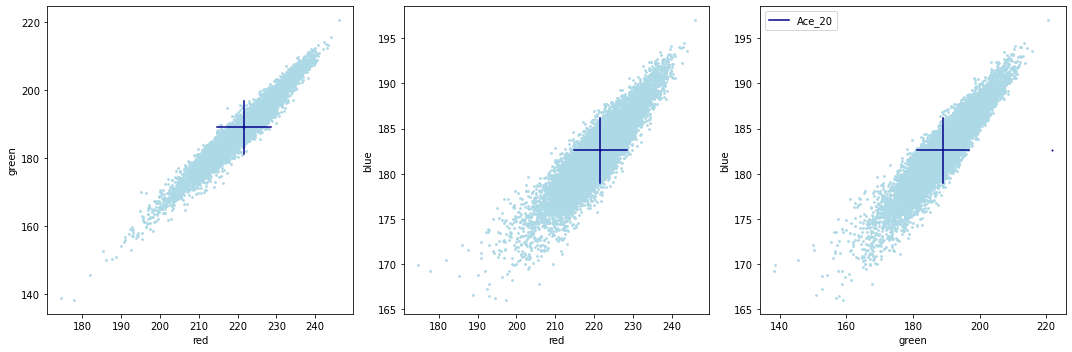

In [13]:
data_report(ace_metadata)
ace_plot=data_plot([ace_metadata], labels=['Ace_20'], save_name='plot_ace')

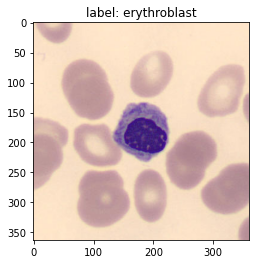

In [14]:
ace_image=data_sample(ace_metadata)

# Matek_19:
- size: 400x400 pixels, 29.0 x 29.0 micrometers
- 11 classes

This dataset is a processed version of the one used by Matek et al. (Matek, 2019) for CNN training and will therefore be further referenced as Mat_19. It consists of 18321 samples, categorized into 11 classes, including the labels basophil, eosinophil and erythroblasts, further typical lymphocytes, monoblasts and monocytes, banded and segmented neutrophils and also several stages of immature granulocytes: myeloblasts, promyelocytes, myelocytes and metamyelocytes. Further each sample has a size of 400 x 400 pixels, corresponding to 29 x 29 micrometers.

More information about the original dataset can be found online under:
(https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=61080958).

In [15]:
label_list_all = [
        'basophil',
        'eosinophil',
        'erythroblast',
        'myeloblast',
        'promyelocyte',
        'myelocyte',
        'metamyelocyte',
        'neutrophil_banded',
        'neutrophil_segmented',
        'monocyte',
        'lymphocyte_typical'
]

label 	 	 	images

total 	 	 	18321
neutrophil_segmented    8484
lymphocyte_typical      3937
myeloblast              3268
monocyte                1815
eosinophil               424
neutrophil_banded        109
basophil                  79
erythroblast              78
promyelocyte              70
myelocyte                 42
metamyelocyte             15
Name: label, dtype: int64
mean 	 	std
red: 209.33 	red: 11.69
green: 185.69 	green: 14.45
blue: 213.28 	blue: 10.35



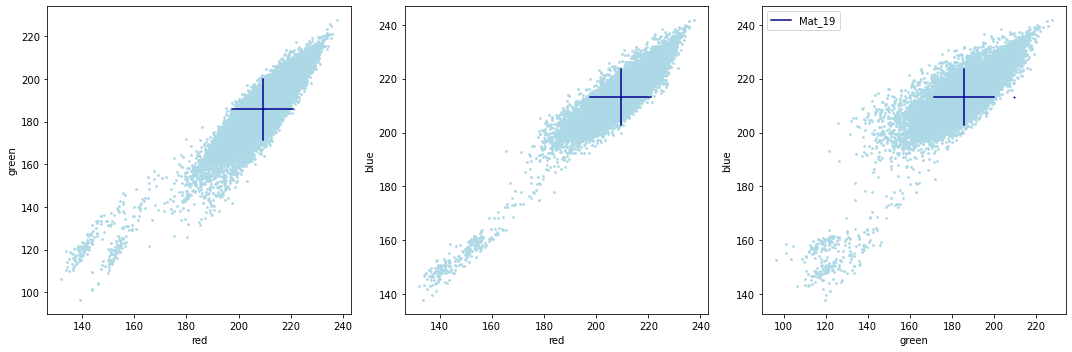

In [16]:
data_report(mat_metadata)
mat_plot=data_plot([mat_metadata], labels=['Mat_19'], save_name='plot_mat')

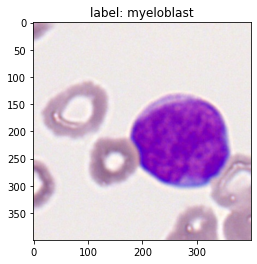

In [17]:
mat_image=data_sample(mat_metadata)

# WBC:
- size: 288x288 pixels, 25.0 x 25.0 micrometers
- 11 classes

label 	 	 	images

total 	 	 	1591
DATA-VAL    1591
Name: label, dtype: int64
mean 	 	std
red: 188.79 	red: 21.36
green: 166.21 	green: 24.45
blue: 198.67 	blue: 17.92



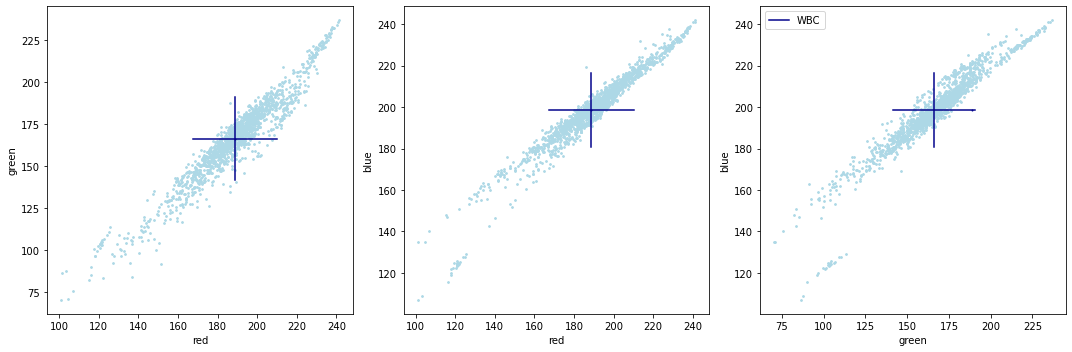

In [19]:
data_report(wbc_metadata)
wbc_plot=data_plot([wbc_metadata], labels=['WBC'], save_name='plot_wbc')

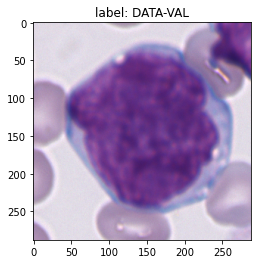

In [20]:
wbc_image=data_sample(wbc_metadata)

# Comparison of datasets and preprocessing:

label 	 	 	images

total 	 	 	34203
neutrophil_segmented    10130
lymphocyte_typical       5101
eosinophil               3491
myeloblast               3268
monocyte                 3185
neutrophil_banded        1742
DATA-VAL                 1591
erythroblast             1577
basophil                 1247
myelocyte                1179
metamyelocyte            1030
promyelocyte              662
Name: label, dtype: int64
mean 	 	std
red: 213.52 	red: 13.4
green: 186.21 	green: 13.7
blue: 199.78 	blue: 17.28



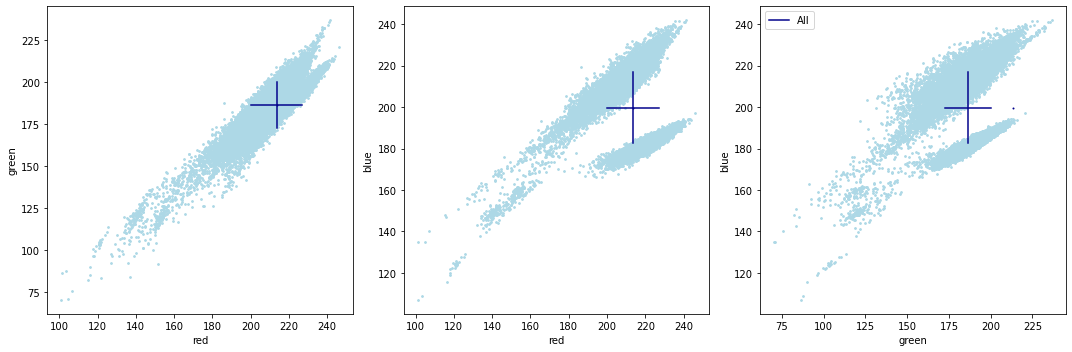

In [21]:
data_report()
all_plot1=data_plot([metadata], labels=['All'], save_name='plot_all1')

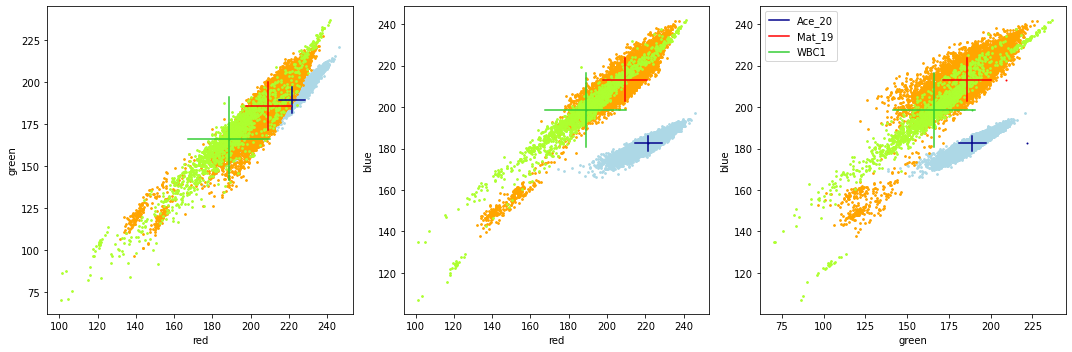

In [22]:
all_plot2=data_plot(save_name='plot_all2')

### Images center-cropped to 25x25 micrometers

In [23]:
crop_Ace20=250
crop_Mat19=345
crop_WBC1=288

dataset_image_size = {
    "Ace_20":crop_Ace20,   #250,
    "Mat_19":crop_Mat19,   #345, 
    "WBC1":crop_WBC1,   #288,  
}

In [24]:
def crop(image, crop_size):
    h1 = (image.shape[0] - crop_size) /2
    h1 = int(h1)
    h2 = (image.shape[0] + crop_size) /2
    h2 = int(h2)

    w1 = (image.shape[1] - crop_size) /2
    w1 = int(w1)
    w2 = (image.shape[1] + crop_size) /2
    w2 = int(w2)
    cropped_image = image[h1:h2,w1:w2, :]
    return cropped_image

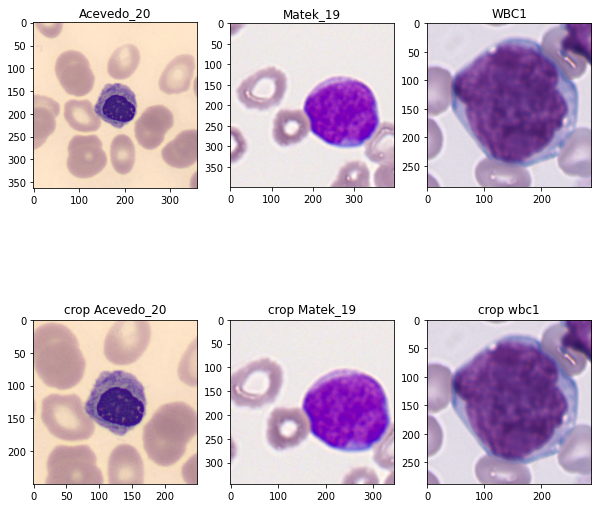

In [25]:
f, axarr = plt.subplots(2,3, figsize=(10,10))

axarr[0,0].set_title('Acevedo_20')
axarr[0,0].imshow(ace_image)
axarr[0,1].set_title('Matek_19')
axarr[0,1].imshow(mat_image)
axarr[0,2].set_title('WBC1')
axarr[0,2].imshow(wbc_image)


axarr[1,0].set_title('crop Acevedo_20')
axarr[1,0].imshow(crop(ace_image, crop_Ace20))
axarr[1,1].set_title('crop Matek_19')
axarr[1,1].imshow(crop(mat_image, crop_Mat19))
axarr[1,2].set_title('crop wbc1')
axarr[1,2].imshow(crop(wbc_image, crop_WBC1))

We advice to use the cropped images as this keeps the ratio of the area of the cell compared to background similar for all datasets

# Dummy Submission

Here a dummy CSV submission example is generated. No training is involved, but classes are randomly generated for the images. 
(here we use a constant classifier model for instance (sklearn's DummyClassifier for instance).)
It's the simplest example for the participants to start with. 

Our WBC1 dataframe now looks like this:

In [26]:
print(wbc_metadata)

         Image                             file     label dataset    set  \
0        0.TIF     Datasets/WBC1/DATA-VAL/0.TIF  DATA-VAL    WBC1  train   
1        1.TIF     Datasets/WBC1/DATA-VAL/1.TIF  DATA-VAL    WBC1  train   
2       10.TIF    Datasets/WBC1/DATA-VAL/10.TIF  DATA-VAL    WBC1  train   
3      100.TIF   Datasets/WBC1/DATA-VAL/100.TIF  DATA-VAL    WBC1  train   
4     1000.TIF  Datasets/WBC1/DATA-VAL/1000.TIF  DATA-VAL    WBC1  train   
...        ...                              ...       ...     ...    ...   
1586   995.TIF   Datasets/WBC1/DATA-VAL/995.TIF  DATA-VAL    WBC1  train   
1587   996.TIF   Datasets/WBC1/DATA-VAL/996.TIF  DATA-VAL    WBC1  train   
1588   997.TIF   Datasets/WBC1/DATA-VAL/997.TIF  DATA-VAL    WBC1  train   
1589   998.TIF   Datasets/WBC1/DATA-VAL/998.TIF  DATA-VAL    WBC1  train   
1590   999.TIF   Datasets/WBC1/DATA-VAL/999.TIF  DATA-VAL    WBC1  train   

           mean1       mean2       mean3  
0     217.419078  198.016577  223.372902  
1

For submission we want to bring it into a different form, so it only shows:
- filenames
- the predicted labelnames
- and their IDs

This could be done by using random numbers for the predictions:

In [27]:
outputdata=wbc_metadata.drop(columns=['file','label', 'dataset', 'set', 'mean1', 'mean2', 'mean3'])
outputdata['Label']=None
outputdata['LabelID']=None
for i in range(len(outputdata)):
    outputdata['LabelID'].loc[i]=random.randint(0, 10) #for the 10 possible classes
    outputdata['Label'].loc[i]=label_map_reverse[outputdata['LabelID'].loc[i]]
outputdata.to_csv('submission.csv', index=False)
print(outputdata)

         Image                 Label LabelID
0        0.TIF              monocyte       9
1        1.TIF  neutrophil_segmented       8
2       10.TIF          promyelocyte       4
3      100.TIF     neutrophil_banded       7
4     1000.TIF            eosinophil       1
...        ...                   ...     ...
1586   995.TIF             myelocyte       5
1587   996.TIF             myelocyte       5
1588   997.TIF    lymphocyte_typical      10
1589   998.TIF          promyelocyte       4
1590   999.TIF     neutrophil_banded       7

[1591 rows x 3 columns]


You can now upload it to the leaderboard of the challenge website and see what performace you get for random!

# Baseline simple solution

## Data loading
Load the data: Now the Acevedo_20 and Matek_19 datasets will be loaded and used for training.

In [28]:
example_metadata=metadata
source_domains=['Ace_20', 'Mat_19']
source_index = example_metadata.dataset.isin(source_domains)
example_metadata = example_metadata.loc[source_index,:].copy().reset_index(drop = True)

In [29]:
print('\033[1m' + 'label \t \t \timages'+ '\033[0m')
print('')
print(f'total \t \t \t{len(example_metadata)}')
print(example_metadata.label.value_counts())

label 	 	 	images

total 	 	 	32612
neutrophil_segmented    10130
lymphocyte_typical       5101
eosinophil               3491
myeloblast               3268
monocyte                 3185
neutrophil_banded        1742
erythroblast             1577
basophil                 1247
myelocyte                1179
metamyelocyte            1030
promyelocyte              662
Name: label, dtype: int64


Then the dataset will be divided into train-, validation- and a testset.

In [30]:
test_fraction=0.2 #of the whole dataset
val_fraction=0.125 #of 0.8 of the dataset (corresponds to 0.1 of the whole set)

In [31]:
train_index, test_index, train_label, test_label = train_test_split(
    example_metadata.index,
    example_metadata.label + "_" + example_metadata.dataset,
    test_size=test_fraction,
    random_state=0, 
    shuffle=True,
    stratify=example_metadata.label
    )
example_metadata.loc[test_index, 'set']='test'
train_val_metadata=example_metadata.loc[train_index]

In [32]:
train_index, val_index, train_label, val_label = train_test_split(
    train_val_metadata.index,
    train_val_metadata.label + "_" + train_val_metadata.dataset,
    test_size=val_fraction,
    random_state=0, 
    shuffle=True, 
    stratify=train_val_metadata.label
    )
example_metadata.loc[val_index, 'set']='val'

See this for a summary of our dataset-fractions

In [33]:
train_size=len(example_metadata.loc[example_metadata['set'] == 'train'])
val_size=len(example_metadata.loc[example_metadata['set'] == 'val'])
test_size=len(example_metadata.loc[example_metadata['set'] == 'test'])

print('\033[1m' + 'complete dataset'+ '\033[0m')
print('\033[1m' + 'label \t \t \timages'+ '\033[0m')
print('')
print(f'total \t \t \t{len(example_metadata)}')
print(example_metadata.label.value_counts())
print('')
print('\033[1m' + 'trainset'+ '\033[0m')
print('\033[1m' + 'label \t \t \timages'+ '\033[0m')
print('')
print(f'total \t \t \t{train_size}')
print(example_metadata.loc[example_metadata['set'] == 'train'].label.value_counts())
print('')
print('\033[1m' + 'validationset'+ '\033[0m')
print('\033[1m' + 'label \t \t \timages'+ '\033[0m')
print('')
print(f'total \t \t \t{val_size}')
print(example_metadata.loc[example_metadata['set'] == 'val'].label.value_counts())
print('')
print('\033[1m' + 'testset'+ '\033[0m')
print('\033[1m' + 'label \t \t \timages'+ '\033[0m')
print('')
print(f'total \t \t \t{test_size}')
print(example_metadata.loc[example_metadata['set'] == 'test'].label.value_counts())

complete dataset
label 	 	 	images

total 	 	 	32612
neutrophil_segmented    10130
lymphocyte_typical       5101
eosinophil               3491
myeloblast               3268
monocyte                 3185
neutrophil_banded        1742
erythroblast             1577
basophil                 1247
myelocyte                1179
metamyelocyte            1030
promyelocyte              662
Name: label, dtype: int64

trainset
label 	 	 	images

total 	 	 	22827
neutrophil_segmented    7091
lymphocyte_typical      3571
eosinophil              2444
myeloblast              2287
monocyte                2229
neutrophil_banded       1219
erythroblast            1103
basophil                 873
myelocyte                825
metamyelocyte            721
promyelocyte             464
Name: label, dtype: int64

validationset
label 	 	 	images

total 	 	 	3262
neutrophil_segmented    1013
lymphocyte_typical       510
eosinophil               349
myeloblast               327
monocyte                 319
neutr

Now the dataset can be loaded. To enable cropping we present a costum DatasetGenerator class, that loads the images from the paths listed in the dataframe.

In [34]:
class DatasetGenerator(Dataset):

    def __init__(self, 
                metadata, 
                reshape_size=64, 
                label_map=[],
                dataset = [],
                transform=None,
                selected_channels = [0,1,2],
                dataset_image_size=None):

        self.metadata = metadata.copy().reset_index(drop = True)
        self.label_map = label_map
        self.transform = transform
        self.selected_channels = selected_channels
    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        ## get image and label
        dataset =  self.metadata.loc[idx,"dataset"]
        crop_size = dataset_image_size[dataset]
        
        h5_file_path = self.metadata.loc[idx,"file"]
        image= imread(h5_file_path)[:,:,self.selected_channels]
        image = image / 255.
        h1 = (image.shape[0] - crop_size) /2
        h1 = int(h1)
        h2 = (image.shape[0] + crop_size) /2
        h2 = int(h2)
        
        w1 = (image.shape[1] - crop_size) /2
        w1 = int(w1)
        w2 = (image.shape[1] + crop_size) /2
        w2 = int(w2)
        image = image[h1:h2,w1:w2, :]
        image = np.transpose(image, (2, 0, 1))
        label = self.metadata.loc[idx,"label"]
 

        # map numpy array to tensor
        image = torch.from_numpy(copy.deepcopy(image)) 
        image = image.float()
        
        if self.transform:
            image = self.transform(image) 
        
        label = self.label_map[label]
        label = torch.tensor(label).long()
        return image.float(),  label

We also want transformations. These you can easily change to your needs below.

- resizing of the images to 224 x 224 pixels
- random crop
- number workers: 3
- mean and standartdeviations used for datanormalization
- batchsize: 32

In [35]:
resize=224 #image pixel size
number_workers=3

random_crop_scale=(0.8, 1.0)
random_crop_ratio=(0.8, 1.2)

mean=[0.485, 0.456, 0.406] #values from imagenet
std=[0.229, 0.224, 0.225] #values from imagenet

bs=32 #batchsize

Now a train set, validation set and test set will be loaded:

In [36]:
normalization = torchvision.transforms.Normalize(mean,std)

train_transform = transforms.Compose([ 
        normalization,
        transforms.RandomResizedCrop(resize, scale=random_crop_scale, ratio=random_crop_ratio),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip()
])

val_transform = transforms.Compose([ 
        normalization,
        transforms.Resize(resize)])

test_transform = transforms.Compose([ 
        normalization,
        transforms.Resize(resize)])

#dataset-creation

train_dataset = DatasetGenerator(example_metadata.loc[train_index,:], 
                                 reshape_size=resize, 
                                 dataset = source_domains,
                                 label_map=label_map_all, 
                                 transform = train_transform,
                                 )
val_dataset = DatasetGenerator(example_metadata.loc[val_index,:], 
                                 reshape_size=resize, 
                                 dataset = source_domains,
                                 label_map=label_map_all, 
                                 transform = val_transform,
                                 )

test_dataset = DatasetGenerator(example_metadata.loc[test_index,:], 
                                 reshape_size=resize, 
                                 dataset = source_domains,
                                 label_map=label_map_all, 
                                 transform = test_transform,
                                 )
train_loader = DataLoader(
    train_dataset, batch_size=bs, shuffle=True, num_workers=number_workers)
valid_loader = DataLoader(
    val_dataset, batch_size=bs, shuffle=True, num_workers=number_workers)
test_loader = DataLoader(
    test_dataset, batch_size=bs, shuffle=False, num_workers=number_workers)

Now for a last check, this function shows random samples of the dataloader:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


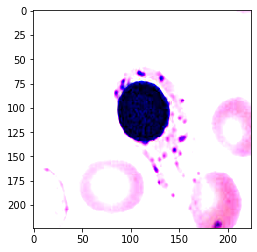

In [37]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    
show((next(iter(train_loader))[0])[0])

## Training

For simplicity and fast training we use a resnet18. We advise participants to stick with this model and not spend time on trying different architectures, but rather focus on the solution to the domain transfer problem.
Settings:

In [38]:
epochs=20 # max number of epochs
lr=0.001 # learning rate
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

Loading a resnet18 model

In [39]:
num_classes = len(label_map_all)
model = resnet18(pretrained=True) # remove this if the model was already instansiated in the cell above
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model = nn.DataParallel(model) 
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [40]:
model_save_path='model' #path where model with best f1_macro should be stored

#running variables
epoch=0
update_frequency=5 # number of batches before viewed acc and loss get updated
counter=0 #counts batches
f1_macro_best=0 #minimum f1_macro_score of the validation set for the first model to be saved
loss_running=0
acc_running=0
val_batches=0

y_pred=torch.tensor([], dtype=int)
y_true=torch.tensor([], dtype=int)
y_pred=y_pred.to(device)
y_true=y_true.to(device)


#Training

for epoch in range(0, epochs):
    #training
    model.train()
    
    with tqdm(train_loader) as tepoch:   
        for i, data in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch+1}")
            counter+=1

            x, y = data
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()

            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            logits = torch.softmax(out.detach(), dim=1)
            predictions = logits.argmax(dim=1)
            acc = accuracy_score(y.cpu(), predictions.cpu())
            
            if counter >= update_frequency:
                tepoch.set_postfix(loss=loss.item(), accuracy=acc.item())
                counter=0
                
    #validation       
    model.eval()
    with tqdm(valid_loader) as vepoch: 
        for i, data in enumerate(vepoch):
            vepoch.set_description(f"Validation {epoch+1}")

            x, y = data
            x, y = x.to(device), y.to(device)

            out = model(x)
            loss = criterion(out, y)
            
            logits = torch.softmax(out.detach(), dim=1)
            predictions = logits.argmax(dim=1)
            y_pred=torch.cat((y_pred, predictions), 0)
            y_true=torch.cat((y_true, y), 0)
            
            acc = accuracy_score(y_true.cpu(), y_pred.cpu())
            
            loss_running+=(loss.item()*len(y))
            acc_running+=(acc.item()*len(y))
            val_batches+=len(y)
            loss_mean=loss_running/val_batches
            acc_mean=acc_running/val_batches
            
            vepoch.set_postfix(loss=loss_mean, accuracy=acc_mean)
            
        f1_micro=f1_score(y_true.cpu(), y_pred.cpu(), average='micro')
        f1_macro=f1_score(y_true.cpu(), y_pred.cpu(), average='macro')
        print(f'f1_micro: {f1_micro}, f1_macro: {f1_macro}')  
        if f1_macro > f1_macro_best:
            f1_macro_best=f1_macro
            torch.save(model.state_dict(), model_save_path)
            print('model saved')
        
        #reseting running variables
        loss_running=0
        acc_running=0
        val_batches=0
            
        y_pred=torch.tensor([], dtype=int)
        y_true=torch.tensor([], dtype=int)
        y_pred=y_pred.to(device)
        y_true=y_true.to(device)
            
        
    
print('Finished Training')

#loading the model with the highest validation accuracy
model.load_state_dict(torch.load('model'))
print(model)

Finished Training
DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, 

## Evaluation

Now we want to predict on the test datasetsof Acevedo_20 and Matek_19 and visualize the results

In [41]:
metadata_test=example_metadata.loc[test_index,:]
ace_metadata_test=metadata_test.loc[metadata_test['dataset']=='Ace_20'].reset_index(drop = True)
mat_metadata_test=metadata_test.loc[metadata_test['dataset']=='Mat_19'].reset_index(drop = True)

In [42]:
def prediction(metadata=metadata_test, 
               source_domains=['Ace_20', 'Mat_19'], label_map=label_map_all):



    pred_dataset = DatasetGenerator(metadata, 
                                 reshape_size=resize, 
                                 dataset = source_domains,
                                 label_map=label_map, 
                                 transform = test_transform,
                                 )
    
    pred_loader = DataLoader(pred_dataset, 
                             batch_size=1, 
                             shuffle=False, 
                             num_workers=6
                            )
    n=len(pred_loader)
    model.eval()
    preds=torch.tensor([], dtype=int)
    preds=preds.to(device)
    prediction=torch.tensor([])
    prediction=prediction.to(device)
    for i, data in enumerate(pred_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        x, y = data
        x, y = x.to(device), y.to(device)
        out = model(x)
        logits = torch.softmax(out.detach(), dim=1)
        prediction = torch.cat((prediction, logits), 0)
        predic = logits.argmax(dim=1)
        preds=torch.cat((preds, predic), 0)

    preds=preds.cpu()
    preds=preds.detach().numpy()
    np.save('preds', preds)
    y_pred = [label_map_reverse[p] for p in  preds]
    y_true=metadata['label']
    return y_true, y_pred, preds

def classification_complete_report(y_true, y_pred ,labels = None  ): 
    print(classification_report(y_true, y_pred, labels = None))
    print(15*"----")
    print("matthews correlation coeff: %.4f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.4f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.4f & balanced Accuracy: %.4f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    #print("macro F1 score: %.4f & micro F1 score: %.4f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.4f & micro Precision score: %.4f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.4f & micro Recall score: %.4f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    print(labels)
    cm = confusion_matrix(y_true, y_pred,labels= labels, normalize='true')
    fig, ax = plt.subplots(figsize=(10, 10)) #plot size
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax, include_values=False, colorbar=False)
    
    plt.show()
    print(15*"----")

## Acevedo_20

                      precision    recall  f1-score   support

            basophil       0.95      1.00      0.97       230
          eosinophil       1.00      1.00      1.00       610
        erythroblast       1.00      1.00      1.00       298
  lymphocyte_typical       0.98      1.00      0.99       201
       metamyelocyte       0.82      0.68      0.75       203
            monocyte       0.99      0.96      0.97       263
           myelocyte       0.76      0.83      0.79       228
   neutrophil_banded       0.71      0.89      0.79       320
neutrophil_segmented       0.89      0.75      0.81       340
        promyelocyte       0.89      0.74      0.81       119

            accuracy                           0.90      2812
           macro avg       0.90      0.88      0.89      2812
        weighted avg       0.91      0.90      0.90      2812

------------------------------------------------------------
matthews correlation coeff: 0.8920
Cohen Kappa score: 0.8912
Accurac

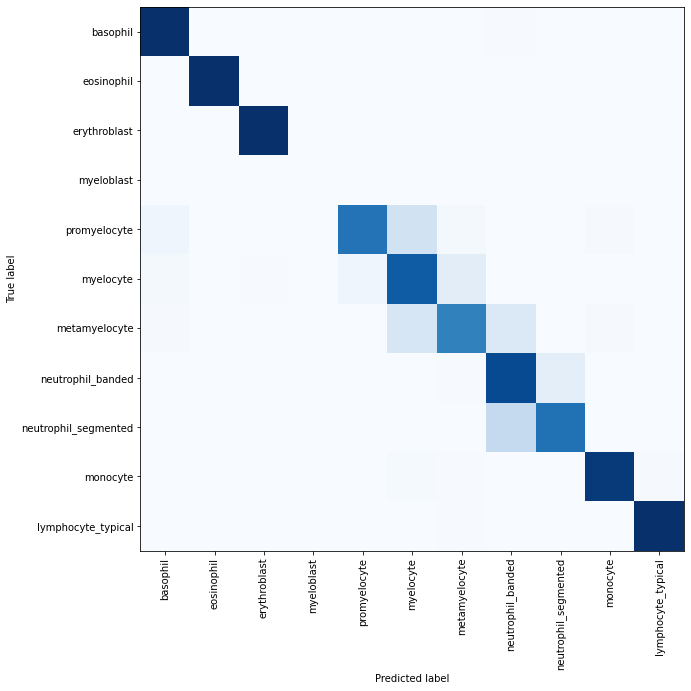

------------------------------------------------------------


In [43]:
y_true, y_pred, preds=prediction(metadata= ace_metadata_test, source_domains=['Ace_20'])
classification_complete_report(y_true, y_pred, labels=label_list_all)

## Matek_19

                      precision    recall  f1-score   support

            basophil       0.70      0.74      0.72        19
          eosinophil       0.92      0.97      0.94        88
        erythroblast       0.94      0.94      0.94        18
  lymphocyte_typical       0.92      0.98      0.95       819
       metamyelocyte       0.00      0.00      0.00         3
            monocyte       0.89      0.93      0.91       374
          myeloblast       0.96      0.88      0.92       654
           myelocyte       0.33      0.25      0.29         8
   neutrophil_banded       1.00      0.03      0.07        29
neutrophil_segmented       0.98      0.99      0.99      1686
        promyelocyte       0.67      0.62      0.64        13

            accuracy                           0.95      3711
           macro avg       0.76      0.67      0.67      3711
        weighted avg       0.95      0.95      0.94      3711

------------------------------------------------------------
matthe

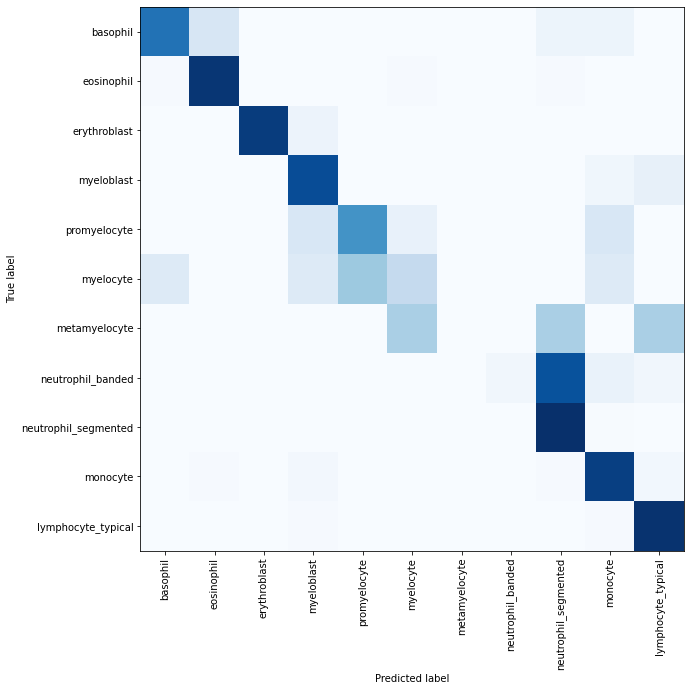

------------------------------------------------------------


In [44]:
y_true, y_pred, preds=prediction(metadata= mat_metadata_test, source_domains=['Mat_19'])
classification_complete_report(y_true, y_pred, labels=label_list_all)

## WBC

In [45]:
y_true, y_pred, preds=prediction(metadata=wbc_metadata, source_domains=['WBC1'], label_map=label_map_pred)

Now a submission file for the prediction on WBC1 will be computed

In [46]:
outputdata=wbc_metadata.drop(columns=['file', 'label', 'dataset', 'set', 'mean1', 'mean2', 'mean3'])
outputdata['Label']=y_pred
outputdata['LabelID']=preds
'''
for i in range(len(y_pred)):
    outputdata['LabelID'].loc[i]=y_pred[i]
    outputdata['Label'].loc[i]=label_map_reverse[y_pred[i]]
'''
outputdata.to_csv('submission.csv')
print(outputdata)

         Image               Label  LabelID
0        0.TIF  lymphocyte_typical       10
1        1.TIF          eosinophil        1
2       10.TIF  lymphocyte_typical       10
3      100.TIF  lymphocyte_typical       10
4     1000.TIF  lymphocyte_typical       10
...        ...                 ...      ...
1586   995.TIF        erythroblast        2
1587   996.TIF  lymphocyte_typical       10
1588   997.TIF  lymphocyte_typical       10
1589   998.TIF  lymphocyte_typical       10
1590   999.TIF  lymphocyte_typical       10

[1591 rows x 3 columns]


In [47]:
!head submission.csv

,Image,Label,LabelID
0,0.TIF,lymphocyte_typical,10
1,1.TIF,eosinophil,1
2,10.TIF,lymphocyte_typical,10
3,100.TIF,lymphocyte_typical,10
4,1000.TIF,lymphocyte_typical,10
5,1001.TIF,erythroblast,2
6,1002.TIF,eosinophil,1
7,1003.TIF,eosinophil,1
8,1004.TIF,neutrophil_segmented,8


Now, you can open the submision.csv file (File -> Open) file and download it!

After you download it, you can upload it to the frontend, here: XXX (direct link to the challenge)

###  Authors

Armin Gruber

Ali Boushehri

Christina Bukas
